In [2]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils

In [3]:
models_folder = '../../saved/models'
model_name = '20201010_setnet_mono_best'
results_folder = '../../saved/results'
results_subfolder = '20201010_setnet_mono'

In [4]:
# load model
setnet = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

In [4]:
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

In [5]:
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

In [6]:
# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Best Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

Best Train Accuracy:  50.906882109573445
Epoch:  47

Best Val Accuracy:  41.72337334658613
Epoch:  30

Best Test Accuracy:  41.816013211817236
Epoch:  30



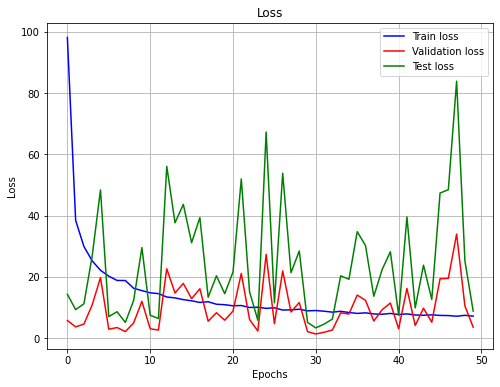

In [7]:
# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

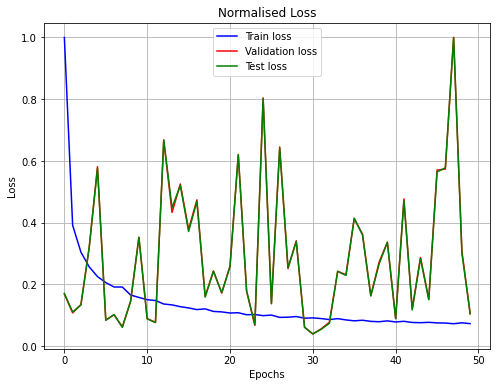

In [8]:
# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

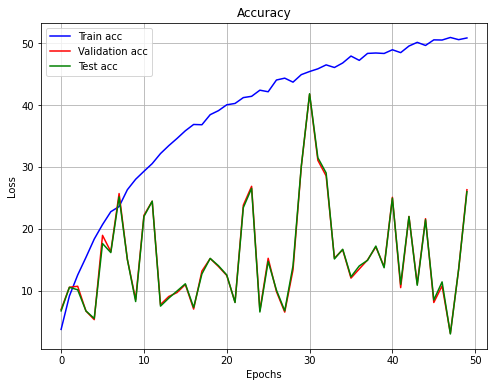

In [9]:
# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_perc_correct, 'b', label='Train acc')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation acc')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# example
best_train_results[0]

array([22144, 'G81-63408-BD2-G5T2-20952',
       array([ 1.   ,  0.327,  0.053, -1.   , -1.   , -1.   ], dtype=float32),
       array([ 1. ,  0.5,  0.2, -1. , -1. , -1. ], dtype=float32)],
      dtype=object)

In [11]:
# Find best performance epoch based on validation
# Extract results from training and test for that epoch
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

Best Validation Accuracy:  41.72337334658613 at epoch  30
Training Accuracy:  45.405272234540526
Test Accuracy:  41.816013211817236


In [12]:
# extract vectors for dataframe
train_indexes = best_train_results[:, 0]
train_filenames = best_train_results[:, 1] 
train_preds = np.stack(best_train_results[:, 2])
train_targets = np.stack(best_train_results[:, 3])
train_abs_err = np.stack(abs(train_preds - train_targets))

val_indexes = best_val_results[:, 0]
val_filenames = best_val_results[:, 1] 
val_preds = np.stack(best_val_results[:, 2])
val_targets = np.stack(best_val_results[:, 3])
val_abs_err = np.stack(abs(val_preds - val_targets))

test_indexes = best_test_results[:, 0]
test_filenames = best_test_results[:, 1] 
test_preds = np.stack(best_test_results[:, 2])
test_targets = np.stack(best_test_results[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

In [13]:
# dataframes
train_df = pd.DataFrame(data={'index': train_indexes, 'filename': train_filenames,
                                'level_pred': train_preds[:,0], 'gain_pred': train_preds[:,1],
                                'tone_eq1_pred': train_preds[:,2], 'tone_eq2_pred': train_preds[:,3],
                                'tone_eq3_pred': train_preds[:,4], 'tone_eq4_pred': train_preds[:,5],
                                'level_targ': train_targets[:,0], 'gain_targ': train_targets[:,1],
                                'tone_eq1_targ': train_targets[:,2], 'tone_eq2_targ': train_targets[:,3],
                                'tone_eq3_targ': train_targets[:,4], 'tone_eq4_targ': train_targets[:,5],
                                'level_abs': train_abs_err[:,0], 'gain_abs': train_abs_err[:,1],
                                'tone_eq1_abs': train_abs_err[:,2], 'tone_eq2_abs': train_abs_err[:,3],
                                'tone_eq3_abs': train_abs_err[:,4], 'tone_eq4_abs': train_abs_err[:,5]})

val_df = pd.DataFrame(data={'index': val_indexes, 'filename': val_filenames,
                                'level_pred': val_preds[:,0], 'gain_pred': val_preds[:,1],
                                'tone_eq1_pred': val_preds[:,2], 'tone_eq2_pred': val_preds[:,3],
                                'tone_eq3_pred': val_preds[:,4], 'tone_eq4_pred': val_preds[:,5],
                                'level_targ': val_targets[:,0], 'gain_targ': val_targets[:,1],
                                'tone_eq1_targ': val_targets[:,2], 'tone_eq2_targ': val_targets[:,3],
                                'tone_eq3_targ': val_targets[:,4], 'tone_eq4_targ': val_targets[:,5],
                                'level_abs': val_abs_err[:,0], 'gain_abs': val_abs_err[:,1],
                                'tone_eq1_abs': val_abs_err[:,2], 'tone_eq2_abs': val_abs_err[:,3],
                                'tone_eq3_abs': val_abs_err[:,4], 'tone_eq4_abs': val_abs_err[:,5]})

test_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})

In [14]:
test_df

,index,filename,level_pred,gain_pred,tone_eq1_pred,tone_eq2_pred,tone_eq3_pred,tone_eq4_pred,level_targ,gain_targ,tone_eq1_targ,tone_eq2_targ,tone_eq3_targ,tone_eq4_targ,level_abs,gain_abs,tone_eq1_abs,tone_eq2_abs,tone_eq3_abs,tone_eq4_abs
0,86820,G71-53303-MT2-G10B0T0ML0MF0-20778,1.0,0.966,0.044,0.000,0.004,0.005,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.034,0.044,0.000,0.004,0.005
1,3416,G81-74610-808-O5T0-20980,1.0,0.238,0.074,-1.000,-1.000,-1.000,1.0,0.5,0.0,-1.0,-1.0,-1.0,0.0,0.262,0.074,0.000,0.000,0.000
2,37645,G63-44104-DPL-D10-20675,1.0,0.871,-0.943,-1.000,-1.000,-1.000,1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.129,0.057,0.000,0.000,0.000
3,157833,G73-58403-TS9-D10T2-20869,1.0,0.796,0.306,-1.000,-1.000,-1.000,1.0,1.0,0.2,-1.0,-1.0,-1.0,0.0,0.204,0.106,0.000,0.000,0.000
4,127712,G61-62407-RBM-T8S5-20639,1.0,0.590,0.746,-1.000,-1.000,-1.000,1.0,0.5,0.8,-1.0,-1.0,-1.0,0.0,0.090,0.054,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32693,56906,G91-43103-MGS-D8T10-21064,1.0,0.747,0.867,-1.000,-1.000,-1.000,1.0,0.8,1.0,-1.0,-1.0,-1.0,0.0,0.053,0.133,0.000,0.000,0.000
32694,106179,G63-55210-MT2-G8B0T0ML10MF10-20694,1.0,0.803,0.024,0.003,1.000,0.998,1.0,0.8,0.0,0.0,1.0,1.0,0.0,0.003,0.024,0.003,0.000,0.002
32695,7484,G83-66507-808-O8T10-21042,1.0,0.786,0.788,-1.000,-1.000,-1.000,1.0,0.8,1.0,-1.0,-1.0,-1.0,0.0,0.014,0.212,0.000,0.000,0.000
32696,71734,G93-48108-MT2-G5B10T10ML10MF10-21147,1.0,0.535,1.000,1.000,1.000,1.000,1.0,0.5,1.0,1.0,1.0,1.0,0.0,0.035,0.000,0.000,0.000,0.000


In [15]:
# Mean Absolute Errors
level_mae = sum(test_df.level_abs)/test_set_size
gain_mae = sum(test_df.gain_abs)/test_set_size
tone_eq1_mae = sum(test_df.tone_eq1_abs)/test_set_size
tone_eq2_mae = sum(test_df.tone_eq2_abs)/test_set_size
tone_eq3_mae = sum(test_df.tone_eq3_abs)/test_set_size
tone_eq4_mae = sum(test_df.tone_eq4_abs)/test_set_size
print('level_mae: ', level_mae)
print('gain_mae: ', gain_mae)
print('tone_eq1_mae: ', tone_eq1_mae)
print('tone_eq2_mae: ', tone_eq2_mae)
print('tone_eq3_mae: ', tone_eq3_mae)
print('tone_eq4_mae: ', tone_eq4_mae)

level_mae:  9.450110625590715e-06
gain_mae:  0.08868358913816239
tone_eq1_mae:  0.11567141681257054
tone_eq2_mae:  0.0024826895117736805
tone_eq3_mae:  0.004714263570297138
tone_eq4_mae:  0.003805706465727306


In [16]:
df = pd.DataFrame(data={'Level': test_df.level_abs,
                        'Gain': test_df.gain_abs,
                        'Tone/Eq 1': test_df.tone_eq1_abs,
                        'Tone/Eq 2': test_df.tone_eq2_abs,
                        'Tone/Eq 3': test_df.tone_eq3_abs,
                        'Tone/Eq 4': test_df.tone_eq4_abs,
                        })
df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.0,0.034,0.044,0.000,0.004,0.005
1,0.0,0.262,0.074,0.000,0.000,0.000
2,0.0,0.129,0.057,0.000,0.000,0.000
3,0.0,0.204,0.106,0.000,0.000,0.000
4,0.0,0.090,0.054,0.000,0.000,0.000
...,...,...,...,...,...,...
32693,0.0,0.053,0.133,0.000,0.000,0.000
32694,0.0,0.003,0.024,0.003,0.000,0.002
32695,0.0,0.014,0.212,0.000,0.000,0.000
32696,0.0,0.035,0.000,0.000,0.000,0.000


[(0.0, 0.5)]

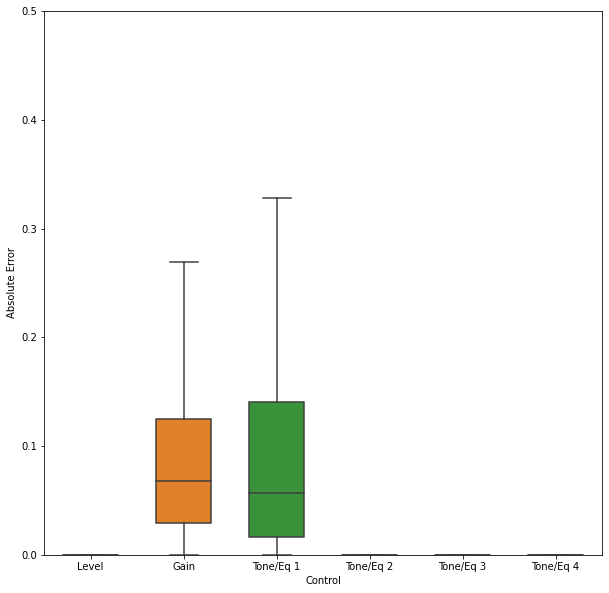

In [17]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.5))

In [18]:
mt2 = test_df[test_df['filename'].str.contains('MT2')]
mt2 = pd.DataFrame(data={'Level': mt2.level_abs,
                        'Gain': mt2.gain_abs,
                        'Tone/Eq 1': mt2.tone_eq1_abs,
                        'Tone/Eq 2': mt2.tone_eq2_abs,
                        'Tone/Eq 3': mt2.tone_eq3_abs,
                        'Tone/Eq 4': mt2.tone_eq4_abs,
                        })
mt2

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.0,0.034,0.044,0.000,0.004,0.005
5,0.0,0.204,0.025,0.001,0.010,0.008
15,0.0,0.215,0.007,0.004,0.004,0.001
16,0.0,0.017,0.012,0.000,0.000,0.000
20,0.0,0.020,0.009,0.001,0.000,0.001
...,...,...,...,...,...,...
32681,0.0,0.241,0.007,0.000,0.000,0.000
32684,0.0,0.079,0.052,0.003,0.006,0.000
32687,0.0,0.071,0.009,0.007,0.004,0.012
32694,0.0,0.003,0.024,0.003,0.000,0.002


[(0.0, 0.5)]

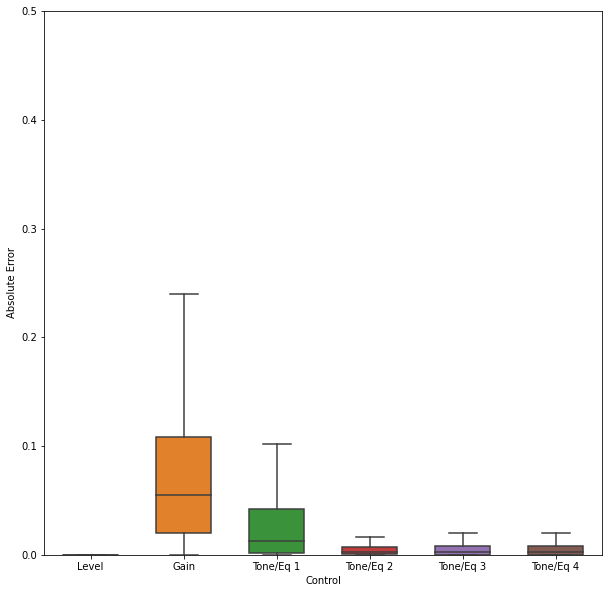

In [19]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(mt2), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(mt2), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.5))

<AxesSubplot:xlabel='gain_pred'>

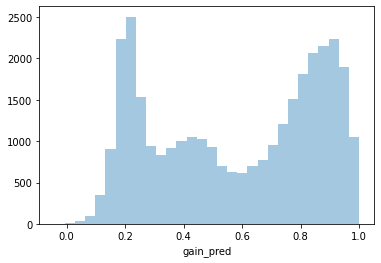

In [20]:
sns.distplot(test_df['gain_pred'], kde=False, hist=True, rug=False)

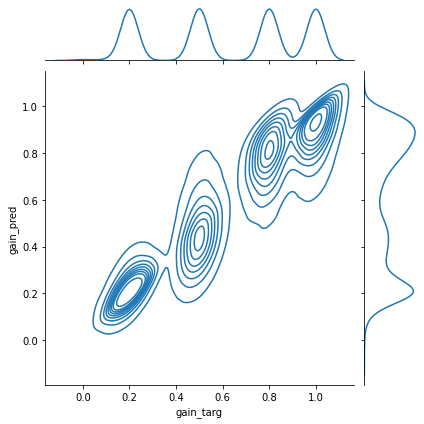

In [20]:
sns.jointplot(x='gain_targ', y='gain_pred', data=test_df, kind='kde');

### TEST on MONO RANDOM

In [21]:
# dataset
dataset_mono_rnd = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Mono_Random',
                            excl_folders=['NoFX_mono_preprocessed'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_mono_rnd.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_mono_rnd = datasplit.DataSplit(dataset_mono_rnd, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_mono_rnd = split_mono_rnd.get_split(batch_size=100)

In [22]:
len(dataset_mono_rnd)

14000

In [23]:
test_mono_rnd_loss, test_mono_rnd_correct, test_mono_rnd_results = trainer.test_settings_net(
        model=setnet, 
        test_loader=test_loader_mono_rnd, 
        test_sampler=split_mono_rnd.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 5.7884	 Avg Loss: 0.0004	Correct: 4274/14000	Percentage Correct: 30.53


In [27]:
test_mono_rnd_results[0]

(1721,
 'G93-57402-BD2-G10T1.6-21180',
 array([ 1.   ,  0.819, -0.048, -1.   , -1.   , -1.   ], dtype=float32),
 array([ 1.  ,  1.  ,  0.16, -1.  , -1.  , -1.  ], dtype=float32))

In [28]:
# dataframe
test_mono_rnd_results_npy = np.array(test_mono_rnd_results)
test_indexes = test_mono_rnd_results_npy[:, 0]
test_filenames = test_mono_rnd_results_npy[:, 1] 
test_preds = np.stack(test_mono_rnd_results_npy[:, 2])
test_targets = np.stack(test_mono_rnd_results_npy[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

test_mono_rnd_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})
test_mono_rnd_df

,index,filename,level_pred,gain_pred,tone_eq1_pred,tone_eq2_pred,tone_eq3_pred,tone_eq4_pred,level_targ,gain_targ,tone_eq1_targ,tone_eq2_targ,tone_eq3_targ,tone_eq4_targ,level_abs,gain_abs,tone_eq1_abs,tone_eq2_abs,tone_eq3_abs,tone_eq4_abs
0,1721,G93-57402-BD2-G10T1.6-21180,1.0,0.819,-0.048,-1.000,-1.0,-1.0,1.0,1.00,0.16,-1.0,-1.0,-1.0,0.0,0.181,0.208,0.000,0.0,0.0
1,13804,G91-58308-VTB-F9.9-21095,1.0,0.908,-0.989,-1.000,-1.0,-1.0,1.0,0.97,-1.00,-1.0,-1.0,-1.0,0.0,0.062,0.011,0.000,0.0,0.0
2,6912,G91-56401-MGS-D8T3.9-21101,1.0,0.761,0.576,-1.000,-1.0,-1.0,1.0,0.80,0.39,-1.0,-1.0,-1.0,0.0,0.039,0.186,0.000,0.0,0.0
3,1985,G71-57402-BD2-G5.2T9.4-20790,1.0,0.302,0.497,-0.996,-1.0,-1.0,1.0,0.52,0.94,-1.0,-1.0,-1.0,0.0,0.218,0.443,0.004,0.0,0.0
4,1898,G93-51301-BD2-G1.1T2.7-21166,1.0,0.206,0.548,-1.000,-1.0,-1.0,1.0,0.11,0.27,-1.0,-1.0,-1.0,0.0,0.096,0.278,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,2298,G71-67412-BMF-S5.2T1.3-20800,1.0,0.343,0.082,-1.000,-1.0,-1.0,1.0,0.52,0.13,-1.0,-1.0,-1.0,0.0,0.177,0.048,0.000,0.0,0.0
13996,829,G93-69605-808-O0.1T0.1-21209,1.0,0.241,0.073,-1.000,-1.0,-1.0,1.0,0.01,0.01,-1.0,-1.0,-1.0,0.0,0.231,0.063,0.000,0.0,0.0
13997,4120,G63-44104-DS1-D0.9T0.3-20675,1.0,0.145,0.168,-1.000,-1.0,-1.0,1.0,0.09,0.03,-1.0,-1.0,-1.0,0.0,0.055,0.138,0.000,0.0,0.0
13998,4037,G91-55400-DS1-D2T0.1-21100,1.0,0.124,0.129,-1.000,-1.0,-1.0,1.0,0.20,0.01,-1.0,-1.0,-1.0,0.0,0.076,0.119,0.000,0.0,0.0


In [29]:
# Mean Absolute Errors
level_mae_mono_rnd = sum(test_mono_rnd_df.level_abs)/len(dataset_mono_rnd)
gain_mae_mono_rnd = sum(test_mono_rnd_df.gain_abs)/len(dataset_mono_rnd)
tone_eq1_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq1_abs)/len(dataset_mono_rnd)
tone_eq2_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq2_abs)/len(dataset_mono_rnd)
tone_eq3_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq3_abs)/len(dataset_mono_rnd)
tone_eq4_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq4_abs)/len(dataset_mono_rnd)
print('level_mae: ', level_mae_mono_rnd)
print('gain_mae: ', gain_mae_mono_rnd)
print('tone_eq1_mae: ', tone_eq1_mae_mono_rnd)
print('tone_eq2_mae: ', tone_eq2_mae_mono_rnd)
print('tone_eq3_mae: ', tone_eq3_mae_mono_rnd)
print('tone_eq4_mae: ', tone_eq4_mae_mono_rnd)

level_mae:  1.5714168548583985e-06
gain_mae:  0.09257650030257979
tone_eq1_mae:  0.21409785671651896
tone_eq2_mae:  0.03572135705074262
tone_eq3_mae:  0.03475714293158879
tone_eq4_mae:  0.04220628574211151


In [30]:
df2 = pd.DataFrame(data={'Level': test_df.level_abs,
                        'Gain': test_df.gain_abs,
                        'Tone/Eq 1': test_df.tone_eq1_abs,
                        'Tone/Eq 2': test_df.tone_eq2_abs,
                        'Tone/Eq 3': test_df.tone_eq3_abs,
                        'Tone/Eq 4': test_df.tone_eq4_abs,
                        })
df2

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.0,0.034,0.044,0.000,0.004,0.005
1,0.0,0.262,0.074,0.000,0.000,0.000
2,0.0,0.129,0.057,0.000,0.000,0.000
3,0.0,0.204,0.106,0.000,0.000,0.000
4,0.0,0.090,0.054,0.000,0.000,0.000
...,...,...,...,...,...,...
32693,0.0,0.053,0.133,0.000,0.000,0.000
32694,0.0,0.003,0.024,0.003,0.000,0.002
32695,0.0,0.014,0.212,0.000,0.000,0.000
32696,0.0,0.035,0.000,0.000,0.000,0.000


[(0.0, 0.35)]

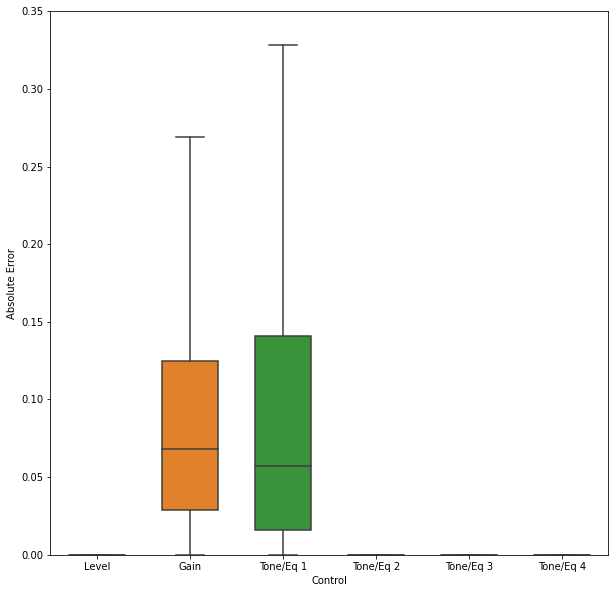

In [33]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df2), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.35))

In [36]:
one_fx_df = test_mono_rnd_df[test_mono_rnd_df['filename'].str.contains('MT2')]
one_fx_df = pd.DataFrame(data={'Level': one_fx_df.level_abs,
                        'Gain': one_fx_df.gain_abs,
                        'Tone/Eq 1': one_fx_df.tone_eq1_abs,
                        'Tone/Eq 2': one_fx_df.tone_eq2_abs,
                        'Tone/Eq 3': one_fx_df.tone_eq3_abs,
                        'Tone/Eq 4': one_fx_df.tone_eq4_abs,
                        })
one_fx_df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
49,0.000,0.027,0.315,0.156,0.252,0.393
51,0.000,0.056,0.046,0.281,0.331,0.465
62,0.003,0.141,0.649,1.446,1.701,1.708
65,0.000,0.112,0.483,0.527,0.689,0.263
88,0.000,0.040,0.178,0.234,0.556,0.054
...,...,...,...,...,...,...
13866,0.000,0.039,0.621,0.833,0.104,0.746
13889,0.000,0.025,0.622,0.118,0.233,0.081
13917,0.000,0.245,0.055,0.255,0.149,0.754
13934,0.000,0.170,0.498,0.053,0.070,0.111


[(0.0, 1.0)]

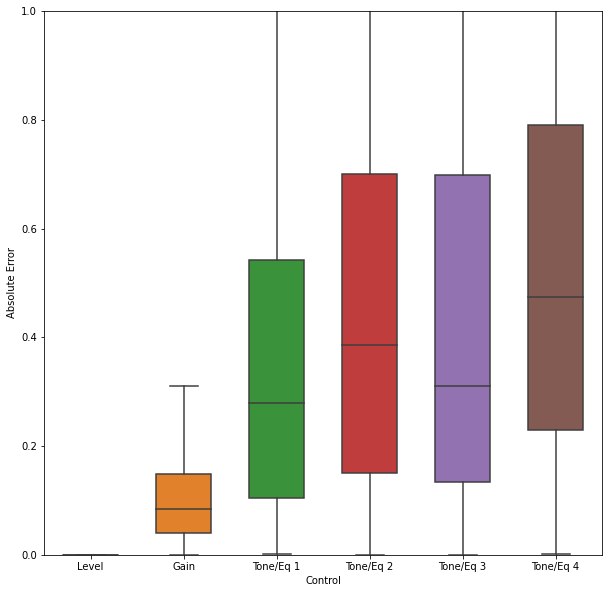

In [41]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(one_fx_df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(mt2), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,1))

### TEST on POLY

In [5]:
# dataset
dataset_poly = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Poly',
                            excl_folders=['NoFX_poly'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_poly.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_poly = datasplit.DataSplit(dataset_poly, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_poly = split_poly.get_split(batch_size=100)

In [6]:
len(dataset_poly)

110040

In [7]:
test_poly_loss, test_poly_correct, test_poly_results = trainer.test_settings_net(
        model=setnet, 
        test_loader=test_loader_poly, 
        test_sampler=split_poly.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 281.3749	 Avg Loss: 0.0026	Correct: 2374/110040	Percentage Correct: 2.16


### TEST on POLY RND

In [8]:
# dataset
dataset_poly_rnd = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Poly_Random',
                            excl_folders=['NoFX_poly'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_poly_rnd.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_poly_rnd = datasplit.DataSplit(dataset_poly_rnd, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_poly_rnd = split_poly_rnd.get_split(batch_size=100)

In [9]:
len(dataset_poly_rnd)

14000

In [10]:
test_loss_poly_rnd, test_correct_poly_rnd, test_results_poly_rnd = trainer.test_settings_net(
        model=setnet, 
        test_loader=test_loader_poly_rnd, 
        test_sampler=split_poly_rnd.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 30.1511	 Avg Loss: 0.0022	Correct: 296/14000	Percentage Correct: 2.11


In [19]:
# SAVE RESULTS for best epoch

# write train results to csv file
train_results_sorted = all_train_results[best_val_idx].tolist()
for i in range(len(train_results_sorted)):
    train_results_sorted[i][0] = int(train_results_sorted[i][0])
train_results_sorted = sorted(train_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'train_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in train_results_sorted:
        wrt.writerow(row)

# write validation results to csv file
val_results_sorted = all_val_results[best_val_idx].tolist()
for i in range(len(val_results_sorted)):
    val_results_sorted[i][0] = int(val_results_sorted[i][0])
val_results_sorted = sorted(val_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'val_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in val_results_sorted:
        wrt.writerow(row)

# write test results to csv file
test_results_sorted = all_test_results[best_val_idx].tolist()
for i in range(len(test_results_sorted)):
    test_results_sorted[i][0] = int(test_results_sorted[i][0])
test_results_sorted = sorted(test_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'test_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in test_results_sorted:
        wrt.writerow(row)